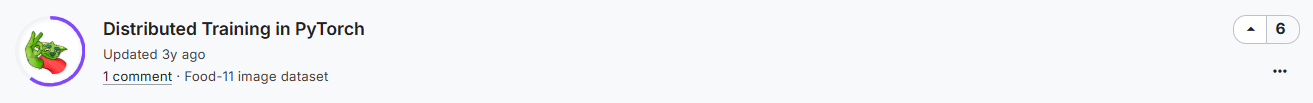

In [1]:
import os
import time
import shutil

from imutils import paths

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torchvision import models
from torchvision import transforms
from torch.cuda.amp import autocast
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.models import densenet121

from sklearn.metrics import classification_report

In [2]:
# define path to the original dataset
DATA_PATH = r"D:\code_study\ML_CODE\dataSets\Classification\Food_11_image_dataset\archive"
DATA_PATH = DATA_PATH.replace("\\", "/")
 
# define base path to store our modified dataset
BASE_PATH = "./"
 
# define paths to separate train, validation, and test splits
TRAIN = os.path.join(BASE_PATH, "training")
VAL = os.path.join(BASE_PATH, "validation")
TEST = os.path.join(BASE_PATH, "evaluation") 

# initialize the list of class label names
CLASSES = ["Bread", "Dairy product", "Dessert", "Egg", "Fried food", "Meat", "Noodles-Pasta", "Rice", "Seafood", "Soup", "Vegetable-Fruit"]
 
# specify ImageNet mean and standard deviation and image size
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 224

# set the device to be used for training and evaluation
DEVICE = torch.device("cuda")
 
# specify training hyperparameters
LOCAL_BATCH_SIZE = 32
PRED_BATCH_SIZE = 4
EPOCHS = 20
LR = 0.0001
 
# define paths to store training plot and trained model
PLOT_PATH = os.path.join("./", "model_training.png")
MODEL_PATH = os.path.join("./", "food_classifier.pth")

In [3]:
def get_dataloader(rootDir, transforms, bs, shuffle=True):
	# create a dataset and use it to create a data loader
	ds = datasets.ImageFolder(root=rootDir, transform=transforms)
	loader = DataLoader(ds, batch_size=bs, shuffle=shuffle, num_workers=os.cpu_count(), pin_memory=True if DEVICE == "cuda" else False)
    
	# return a tuple of the dataset and the data loader
	return (ds, loader)

In [4]:
def copy_images(rootDir, destiDir):
	# get a list of the all the images present in the directory
	imagePaths = list(paths.list_images(rootDir))
	print(f"[INFO] total images found: {len(imagePaths)}...")
    
    # loop over the image paths
	for imagePath in imagePaths:
		# extract class label from the filename
		filename = imagePath.split(os.path.sep)[-1]
		label = imagePath.split(os.path.sep)[-2]
        
		# construct the path to the output directory
		dirPath = os.path.sep.join([destiDir, label])
        
		# if the output directory does not exist, create it
		if not os.path.exists(dirPath):
			os.makedirs(dirPath)
            
		# construct the path to the output image file and copy it
		p = os.path.sep.join([dirPath, filename])
		shutil.copy2(imagePath, p)
        
    # calculate the total number of images in the destination directory and print it
	currentTotal = list(paths.list_images(destiDir))
	print(f"[INFO] total images copied to {destiDir}: {len(currentTotal)}...")

In [5]:
# copy over the images to their respective directories
print("[INFO] copying images...")
copy_images(os.path.join(DATA_PATH, "training"), TRAIN)
copy_images(os.path.join(DATA_PATH, "validation"), VAL)
copy_images(os.path.join(DATA_PATH, "evaluation"), TEST)

[INFO] copying images...
[INFO] total images found: 9866...
[INFO] total images copied to ./training: 9866...
[INFO] total images found: 3430...
[INFO] total images copied to ./validation: 3430...
[INFO] total images found: 3347...
[INFO] total images copied to ./evaluation: 3347...


In [6]:
class FoodClassifier(nn.Module):
	def __init__(self, baseModel, numClasses):
		super(FoodClassifier, self).__init__()
        
		# initialize the base model and the classification layer
		self.baseModel = baseModel
		self.classifier = nn.Linear(baseModel.classifier.in_features, numClasses)
        
		# set the classifier of our base model to produce outputs from the last convolution block
		self.baseModel.classifier = nn.Identity()
        
    # we decorate the *forward()* method with *autocast()* to enable mixed-precision training in a distributed manner
	@autocast()
	def forward(self, x):
		# pass the inputs through the base model and then obtain the classifier outputs
		features = self.baseModel(x)
		logits = self.classifier(features)
        
		# return the classifier outputs
		return logits

C:\Users\Leaper\AppData\Local\Temp\ipykernel_17760\1539599991.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast()


In [7]:
# determine the number of GPUs we have
NUM_GPU = torch.cuda.device_count()
print(f"[INFO] number of GPUs found: {NUM_GPU}...")

# determine the batch size based on the number of GPUs
BATCH_SIZE = LOCAL_BATCH_SIZE * NUM_GPU
print(f"[INFO] using a batch size of {BATCH_SIZE}...")

[INFO] number of GPUs found: 1...
[INFO] using a batch size of 32...


In [8]:
# define augmentation pipelines
trainTansform = transforms.Compose([
	transforms.RandomResizedCrop(IMAGE_SIZE),
	transforms.RandomHorizontalFlip(),
	transforms.RandomRotation(90),
	transforms.ToTensor(),
	transforms.Normalize(mean=MEAN, std=STD)
])

testTransform = transforms.Compose([
	transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
	transforms.ToTensor(),
	transforms.Normalize(mean=MEAN, std=STD)
])

# create data loaders
(trainDS, trainLoader) = get_dataloader(TRAIN, transforms=trainTansform, bs=BATCH_SIZE)
(valDS, valLoader) = get_dataloader(VAL, transforms=testTransform, bs=BATCH_SIZE, shuffle=False)
(testDS, testLoader) = get_dataloader(TEST, transforms=testTransform, bs=BATCH_SIZE, shuffle=False)

In [9]:
# load up the DenseNet121 model
baseModel = densenet121(pretrained=True)

# loop over the modules of the model and if the module is batch norm, set it to non-trainable
for module, param in zip(baseModel.modules(), baseModel.parameters()):
	if isinstance(module, nn.BatchNorm2d):
		param.requires_grad = False
        
# initialize our custom model and flash it to the current device
model = FoodClassifier(baseModel, len(trainDS.classes))
model = model.to(DEVICE)

c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Leaper\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# if we have more than one GPU then parallelize the model
if NUM_GPU > 1:
	model = nn.DataParallel(model)
    
# initialize loss function, optimizer, and gradient scaler
lossFunc = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=LR * NUM_GPU)
scaler = torch.cuda.amp.GradScaler(enabled=True)

# initialize a learning-rate (LR) scheduler to decay the it by a factor of 0.1 after every 10 epochs
lrScheduler = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // BATCH_SIZE
valSteps = len(valDS) // BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "train_acc": [], "val_loss": [],	"val_acc": []}

C:\Users\Leaper\AppData\Local\Temp\ipykernel_17760\2343894900.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)


In [ ]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(EPOCHS)):
	# set the model in training mode
	model.train()
    
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
    
	# initialize the number of correct predictions in the training and validation step
	trainCorrect = 0
	valCorrect = 0
    
	# loop over the training set
	for (x, y) in trainLoader:
		with torch.cuda.amp.autocast(enabled=True):
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
            
			# perform a forward pass and calculate the training loss
			pred = model(x)
			loss = lossFunc(pred, y)
            
		# calculate the gradients
		scaler.scale(loss).backward()
		scaler.step(opt)
		scaler.update()
		opt.zero_grad()
        
		# add the loss to the total training loss so far and calculate the number of correct predictions
		totalTrainLoss += loss.item()
		trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
        
	# update our LR scheduler
	lrScheduler.step()
    
    # switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		model.eval()
        
		# loop over the validation set
		for (x, y) in valLoader:
			with torch.cuda.amp.autocast(enabled=True):
				# send the input to the device
				(x, y) = (x.to(DEVICE), y.to(DEVICE))
                
				# make the predictions and calculate the validation loss
				pred = model(x)
				totalValLoss += lossFunc(pred, y).item()
                
			# calculate the number of correct predictions
			valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()
            
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps
    
	# calculate the training and validation accuracy
	trainCorrect = trainCorrect / len(trainDS)
	valCorrect = valCorrect / len(valDS)
    
    # update our training history
	H["train_loss"].append(avgTrainLoss)
	H["train_acc"].append(trainCorrect)
	H["val_loss"].append(avgValLoss)
	H["val_acc"].append(valCorrect)
    
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(avgValLoss, valCorrect))
    
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\Leaper\AppData\Local\Temp\ipykernel_17760\3282116840.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
C:\Users\Leaper\AppData\Local\Temp\ipykernel_17760\3282116840.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
  5%|▌         | 1/20 [06:57<2:12:17, 417.78s/it]

[INFO] EPOCH: 1/20
Train loss: 1.045259, Train accuracy: 0.6804
Val loss: 0.563144, Val accuracy: 0.8327


In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
with torch.no_grad():
	# set the model in evaluation mode
	model.eval()
    
	# initialize a list to store our predictions
	preds = []
    
	# loop over the test set
	for (x, _) in testLoader:
		# send the input to the device
		x = x.to(DEVICE)
        
		# make the predictions and add them to the list
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())
        
# generate a classification report
print(classification_report(testDS.targets, preds, target_names=testDS.classes))

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)

# serialize the model state to disk
torch.save(model.state_dict(), MODEL_PATH)

In [ ]:
# determine the number of GPUs we have
NUM_GPU = torch.cuda.device_count()
print(f"[INFO] number of GPUs found: {NUM_GPU}...")

# determine the batch size based on the number of GPUs
BATCH_SIZE = PRED_BATCH_SIZE * NUM_GPU
print(f"[INFO] using a batch size of {BATCH_SIZE}...")

# define augmentation pipeline
testTransform = transforms.Compose([
	transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
	transforms.ToTensor(),
	transforms.Normalize(mean=MEAN, std=STD)
])

In [ ]:
TEST = "./evaluation"

# calculate the inverse mean and standard deviation
invMean = [-m/s for (m, s) in zip(MEAN, STD)]
invStd = [1/s for s in STD]

# define our denormalization transform
deNormalize = transforms.Normalize(mean=invMean, std=invStd)

# create test data loader
(testDS, testLoader) = get_dataloader(TEST,	transforms=testTransform, bs=BATCH_SIZE, shuffle=True)

# load up the DenseNet121 model
baseModel = models.densenet121(pretrained=True)

# initialize our food classifier
model = FoodClassifier(baseModel, len(testDS.classes))

# load the model state
model.load_state_dict(torch.load(MODEL_PATH))

In [ ]:
TEST

In [ ]:
# if we have more than one GPU then parallelize the model
if NUM_GPU > 1:
	model = nn.DataParallel(model)
    
# move the model to the device and set it in evaluation mode
model.to(DEVICE)
model.eval()

# grab a batch of test data
batch = next(iter(testLoader))
(images, labels) = (batch[0], batch[1])

# initialize a figure
fig = plt.figure("Results", figsize=(10, 10 * NUM_GPU))

In [ ]:
# switch off autograd
with torch.no_grad():
	# send the images to the device
	images = images.to(DEVICE)
    
	# make the predictions
	preds = model(images)
    
	# loop over all the batch
	for i in range(0, BATCH_SIZE):
		# initialize a subplot
		ax = plt.subplot(BATCH_SIZE, 1, i + 1)
        
		# grab the image, de-normalize it, scale the raw pixel intensities to the range [0, 255], and change the channel
		# ordering from channels first to channels last
		image = images[i]
		image = deNormalize(image).cpu().numpy()
		image = (image * 255).astype("uint8")
		image = image.transpose((1, 2, 0))
        
		# grab the ground truth label
		idx = labels[i].cpu().numpy()
		gtLabel = testDS.classes[idx]
        
		# grab the predicted label
		pred = preds[i].argmax().cpu().numpy()
		predLabel = testDS.classes[pred]
        
		# add the results and image to the plot
		info = "Ground Truth: {}, Predicted: {}".format(gtLabel, predLabel)
		plt.imshow(image)
		plt.title(info)
		plt.axis("off")
        
	# show the plot
	plt.tight_layout()
	plt.show()